<a href="https://colab.research.google.com/github/shoiTK/deep_learning_with_pytorch/blob/main/MyHRnetSeg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#install dataset

In [ ]:
!git clone https://github.com/HRNet/HRNet-Semantic-Segmentation 

In [ ]:
!pip install -r /content/HRNet-Semantic-Segmentation/requirements.txt
!pip install imgaug==0.2.5

In [12]:
!cp /content/drive/MyDrive/cityscapes/gtFine_trainvaltest.zip /content/HRNet-Semantic-Segmentation/data/cityscapes
!unzip /content/HRNet-Semantic-Segmentation/data/cityscapes/gtFine_trainvaltest.zip /content/HRNet-Semantic-Segmentation/data/cityscapes
%cd HRNet-Semantic-Segmentation

In [85]:
!mkdir output
!mkdir log

mkdir: cannot create directory ‘output’: File exists


# Import

In [24]:
import os
import logging
import functools
import numpy as np
import torch
import torch.nn as nn
import torch._utils
import torch.nn.functional as F

# Create Model

In [65]:
BatchNorm2d = nn.BatchNorm2d
BN_MOMENTUM = 0.01
logger = logging.getLogger(__name__)

def conv3x3(in_planes, out_planes, stride=1):
  return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)

class BasicBlock(nn.Module):
  expansion = 1
  def __init__(self, inplanes, planes, stride=1, downsample=None):
    super(BasicBlock, self).__init__()
    self.conv1 = conv3x3(inplanes, planes, stride)
    self.bn1 = BatchNorm2d(planes, momentum=BN_MOMENTUM)
    self.relu = nn.ReLU(inplace=False)
    self.conv2 = conv3x3(planes, planes)
    self.bn2 = BatchNorm2d(planes, momentum=BN_MOMENTUM)
    self.downsample = downsample
    self.stride = stride
  
  def forward(self, x):
    residual = x

    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)

    out = self.conv2(out)
    out = self.bn2(out)

    if self.downsample is not None:
        residual = self.downsample(x)

    out = out + residual
    out = self.relu(out)

    return out


In [66]:
class Bottleneck(nn.Module):
  expansion = 4

  def __init__(self, inplanes, planes, stride=1, downsample=None):
    super(Bottleneck, self).__init__()
    self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
    self.bn1 = BatchNorm2d(planes, momentum=BN_MOMENTUM)
    self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn2 = BatchNorm2d(planes, momentum=BN_MOMENTUM)
    self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
    self.bn3 = BatchNorm2d(planes * self.expansion, momentum=BN_MOMENTUM)
    self.relu = nn.ReLU(inplace=False)
    self.downsample = downsample
    self.stride = stride
  
  def forward(self, x):
    residual = x

    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)

    out = self.conv2(out)
    out = self.bn2(out)
    out = self.relu(out)

    out = self.conv3(out)
    out = self.bn3(out)

    if self.downsample is not None:
        residual = self.downsample(x)

    out = out + residual
    out = self.relu(out)

    return out


In [67]:
class HighResolutionModule(nn.Module):
    def __init__(self, num_branches, blocks, num_blocks, num_inchannels,
                 num_channels, fuse_method, multi_scale_output=True):
      super(HighResolutionModule, self).__init__()
      self._check_branches(num_branches, blocks, num_blocks, num_inchannels, num_channels)

      self.num_inchannels = num_inchannels
      self.fuse_method = fuse_method
      self.num_branches = num_branches

      self.multi_scale_output = multi_scale_output

      self.branches = self._make_branches(num_branches, blocks, num_blocks, num_channels)
      self.fuse_layers = self._make_fuse_layers()
      self.relu = nn.ReLU(inplace=False)

    def _check_branches(self, num_branches, blocks, num_blocks, num_inchannels, num_channels):
      if num_branches != len(num_blocks):
          error_msg = 'NUM_BRANCHES({}) <> NUM_BLOCKS({})'.format(num_branches, len(num_blocks))
          logger.error(error_msg)
          raise ValueError(error_msg)

      if num_branches != len(num_channels):
          error_msg = 'NUM_BRANCHES({}) <> NUM_CHANNELS({})'.format(num_branches, len(num_channels))
          logger.error(error_msg)
          raise ValueError(error_msg)

      if num_branches != len(num_inchannels):
          error_msg = 'NUM_BRANCHES({}) <> NUM_INCHANNELS({})'.format(num_branches, len(num_inchannels))
          logger.error(error_msg)
          raise ValueError(error_msg)

    def _make_one_branch(self, branch_index, block, num_blocks, num_channels, stride=1):
      downsample = None
      if stride != 1 or \
          self.num_inchannels[branch_index] != num_channels[branch_index] * block.expansion:
          downsample = nn.Sequential(
              nn.Conv2d(self.num_inchannels[branch_index],
                        num_channels[branch_index] * block.expansion,
                        kernel_size=1, stride=stride, bias=False),
              BatchNorm2d(num_channels[branch_index] * block.expansion,
                          momentum=BN_MOMENTUM),
          )

      layers = []
      layers.append(block(self.num_inchannels[branch_index],
                          num_channels[branch_index], stride, downsample))
      self.num_inchannels[branch_index] = \
          num_channels[branch_index] * block.expansion
      for i in range(1, num_blocks[branch_index]):
          layers.append(block(self.num_inchannels[branch_index],
                              num_channels[branch_index]))

      return nn.Sequential(*layers)

    def _make_branches(self, num_branches, block, num_blocks, num_channels):
      branches = []

      for i in range(num_branches):
          branches.append(
              self._make_one_branch(i, block, num_blocks, num_channels))

      return nn.ModuleList(branches)

    def _make_fuse_layers(self):
      if self.num_branches == 1:
          return None

      num_branches = self.num_branches
      num_inchannels = self.num_inchannels
      fuse_layers = []
      for i in range(num_branches if self.multi_scale_output else 1):
          fuse_layer = []
          for j in range(num_branches):
              if j > i:
                  fuse_layer.append(nn.Sequential(
                      nn.Conv2d(num_inchannels[j],
                                num_inchannels[i],
                                1,
                                1,
                                0,
                                bias=False),
                      BatchNorm2d(num_inchannels[i], momentum=BN_MOMENTUM)))
              elif j == i:
                  fuse_layer.append(None)
              else:
                  conv3x3s = []
                  for k in range(i-j):
                      if k == i - j - 1:
                          num_outchannels_conv3x3 = num_inchannels[i]
                          conv3x3s.append(nn.Sequential(
                              nn.Conv2d(num_inchannels[j],
                                        num_outchannels_conv3x3,
                                        3, 2, 1, bias=False),
                              BatchNorm2d(num_outchannels_conv3x3, 
                                          momentum=BN_MOMENTUM)))
                      else:
                          num_outchannels_conv3x3 = num_inchannels[j]
                          conv3x3s.append(nn.Sequential(
                              nn.Conv2d(num_inchannels[j],
                                        num_outchannels_conv3x3,
                                        3, 2, 1, bias=False),
                              BatchNorm2d(num_outchannels_conv3x3,
                                          momentum=BN_MOMENTUM),
                              nn.ReLU(inplace=False)))
                  fuse_layer.append(nn.Sequential(*conv3x3s))
          fuse_layers.append(nn.ModuleList(fuse_layer))

      return nn.ModuleList(fuse_layers)

    def get_num_inchannels(self):
      return self.num_inchannels

    def forward(self, x):
      if self.num_branches == 1:
          return [self.branches[0](x[0])]

      for i in range(self.num_branches):
          x[i] = self.branches[i](x[i])

      x_fuse = []
      for i in range(len(self.fuse_layers)):
          y = x[0] if i == 0 else self.fuse_layers[i][0](x[0])
          for j in range(1, self.num_branches):
              if i == j:
                  y = y + x[j]
              elif j > i:
                  width_output = x[i].shape[-1]
                  height_output = x[i].shape[-2]
                  y = y + F.interpolate(
                      self.fuse_layers[i][j](x[j]),
                      size=[height_output, width_output],
                      mode='bilinear')
              else:
                  y = y + self.fuse_layers[i][j](x[j])
          x_fuse.append(self.relu(y))

      return x_fuse

In [77]:
blocks_dict = {
    'BASIC': BasicBlock,
    'BOTTLENECK': Bottleneck
}

class HighResolutionNet(nn.Module):

    def __init__(self, config, **kwargs):
        extra = config['MODEL']['EXTRA']
        super(HighResolutionNet, self).__init__()

        # stem net
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1,
                               bias=False)
        self.bn1 = BatchNorm2d(64, momentum=BN_MOMENTUM)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1,
                               bias=False)
        self.bn2 = BatchNorm2d(64, momentum=BN_MOMENTUM)
        self.relu = nn.ReLU(inplace=False)

        self.stage1_cfg = extra['STAGE1']
        num_channels = self.stage1_cfg['NUM_CHANNELS'][0]
        block = blocks_dict[self.stage1_cfg['BLOCK']]
        num_blocks = self.stage1_cfg['NUM_BLOCKS'][0]
        self.layer1 = self._make_layer(block, 64, num_channels, num_blocks)
        stage1_out_channel = block.expansion*num_channels

        self.stage2_cfg = extra['STAGE2']
        num_channels = self.stage2_cfg['NUM_CHANNELS']
        block = blocks_dict[self.stage2_cfg['BLOCK']]
        num_channels = [
            num_channels[i] * block.expansion for i in range(len(num_channels))]
        self.transition1 = self._make_transition_layer(
            [stage1_out_channel], num_channels)
        self.stage2, pre_stage_channels = self._make_stage(
            self.stage2_cfg, num_channels)

        self.stage3_cfg = extra['STAGE3']
        num_channels = self.stage3_cfg['NUM_CHANNELS']
        block = blocks_dict[self.stage3_cfg['BLOCK']]
        num_channels = [
            num_channels[i] * block.expansion for i in range(len(num_channels))]
        self.transition2 = self._make_transition_layer(
            pre_stage_channels, num_channels)
        self.stage3, pre_stage_channels = self._make_stage(
            self.stage3_cfg, num_channels)

        self.stage4_cfg = extra['STAGE4']
        num_channels = self.stage4_cfg['NUM_CHANNELS']
        block = blocks_dict[self.stage4_cfg['BLOCK']]
        num_channels = [
            num_channels[i] * block.expansion for i in range(len(num_channels))]
        self.transition3 = self._make_transition_layer(
            pre_stage_channels, num_channels)
        self.stage4, pre_stage_channels = self._make_stage(
            self.stage4_cfg, num_channels, multi_scale_output=True)
        
        last_inp_channels = np.int(np.sum(pre_stage_channels))

        self.last_layer = nn.Sequential(
            nn.Conv2d(
                in_channels=last_inp_channels,
                out_channels=last_inp_channels,
                kernel_size=1,
                stride=1,
                padding=0),
            BatchNorm2d(last_inp_channels, momentum=BN_MOMENTUM),
            nn.ReLU(inplace=False),
            nn.Conv2d(
                in_channels=last_inp_channels,
                out_channels=config['DATASET']['NUM_CLASSES'],
                kernel_size=extra['FINAL_CONV_KERNEL'],
                stride=1,
                padding=1 if extra['FINAL_CONV_KERNEL'] == 3 else 0)
        )

    def _make_transition_layer(
            self, num_channels_pre_layer, num_channels_cur_layer):
        num_branches_cur = len(num_channels_cur_layer)
        num_branches_pre = len(num_channels_pre_layer)

        transition_layers = []
        for i in range(num_branches_cur):
            if i < num_branches_pre:
                if num_channels_cur_layer[i] != num_channels_pre_layer[i]:
                    transition_layers.append(nn.Sequential(
                        nn.Conv2d(num_channels_pre_layer[i],
                                  num_channels_cur_layer[i],
                                  3,
                                  1,
                                  1,
                                  bias=False),
                        BatchNorm2d(
                            num_channels_cur_layer[i], momentum=BN_MOMENTUM),
                        nn.ReLU(inplace=False)))
                else:
                    transition_layers.append(None)
            else:
                conv3x3s = []
                for j in range(i+1-num_branches_pre):
                    inchannels = num_channels_pre_layer[-1]
                    outchannels = num_channels_cur_layer[i] \
                        if j == i-num_branches_pre else inchannels
                    conv3x3s.append(nn.Sequential(
                        nn.Conv2d(
                            inchannels, outchannels, 3, 2, 1, bias=False),
                        BatchNorm2d(outchannels, momentum=BN_MOMENTUM),
                        nn.ReLU(inplace=False)))
                transition_layers.append(nn.Sequential(*conv3x3s))

        return nn.ModuleList(transition_layers)

    def _make_layer(self, block, inplanes, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                BatchNorm2d(planes * block.expansion, momentum=BN_MOMENTUM),
            )

        layers = []
        layers.append(block(inplanes, planes, stride, downsample))
        inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(inplanes, planes))

        return nn.Sequential(*layers)

    def _make_stage(self, layer_config, num_inchannels,
                    multi_scale_output=True):
        num_modules = layer_config['NUM_MODULES']
        num_branches = layer_config['NUM_BRANCHES']
        num_blocks = layer_config['NUM_BLOCKS']
        num_channels = layer_config['NUM_CHANNELS']
        block = blocks_dict[layer_config['BLOCK']]
        fuse_method = layer_config['FUSE_METHOD']

        modules = []
        for i in range(num_modules):
            # multi_scale_output is only used last module
            if not multi_scale_output and i == num_modules - 1:
                reset_multi_scale_output = False
            else:
                reset_multi_scale_output = True
            modules.append(
                HighResolutionModule(num_branches,
                                      block,
                                      num_blocks,
                                      num_inchannels,
                                      num_channels,
                                      fuse_method,
                                      reset_multi_scale_output)
            )
            num_inchannels = modules[-1].get_num_inchannels()

        return nn.Sequential(*modules), num_inchannels

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        #print(x.shape)
        x = self.layer1(x)
        #print(x.shape)
        x_list = []
        for i in range(self.stage2_cfg['NUM_BRANCHES']):
            if self.transition1[i] is not None:
                x_list.append(self.transition1[i](x))
            else:
                x_list.append(x)
        y_list = self.stage2(x_list)

        x_list = []
        for i in range(self.stage3_cfg['NUM_BRANCHES']):
            if self.transition2[i] is not None:
                if i < self.stage2_cfg['NUM_BRANCHES']:
                    x_list.append(self.transition2[i](y_list[i]))
                else:
                    x_list.append(self.transition2[i](y_list[-1]))
            else:
                x_list.append(y_list[i])
        y_list = self.stage3(x_list)

        x_list = []
        for i in range(self.stage4_cfg['NUM_BRANCHES']):
            if self.transition3[i] is not None:
                if i < self.stage3_cfg['NUM_BRANCHES']:
                    x_list.append(self.transition3[i](y_list[i]))
                else:
                    x_list.append(self.transition3[i](y_list[-1]))
            else:
                x_list.append(y_list[i])
        x = self.stage4(x_list)
        #print(x.shape)
        # Upsampling
        x0_h, x0_w = x[0].size(2), x[0].size(3)
        #x0_h, x0_w = x0_h* 4, x0_w * 2 
        #print(x0_h, x0_w)
        x1 = F.upsample(x[1], size=(x0_h, x0_w), mode='bilinear')
        x2 = F.upsample(x[2], size=(x0_h, x0_w), mode='bilinear')
        x3 = F.upsample(x[3], size=(x0_h, x0_w), mode='bilinear')

        x = torch.cat([x[0], x1, x2, x3], 1)

        x = self.last_layer(x)

        return x

    def init_weights(self, pretrained='',):
        logger.info('=> init weights from normal distribution')
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.001)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
        if pretrained:
            pretrained_dict = torch.load(pretrained)
            logger.info('=> loading pretrained model {}'.format(pretrained))
            model_dict = self.state_dict()
            pretrained_dict = {k: v for k, v in pretrained_dict.items()
                               if k in model_dict.keys()}
            for k, _ in pretrained_dict.items():
                logger.info(
                    '=> loading {} pretrained model {}'.format(k, pretrained))
            model_dict.update(pretrained_dict)
            self.load_state_dict(model_dict)

def get_seg_model(cfg, **kwargs):
    model = HighResolutionNet(cfg, **kwargs)
    model.init_weights(cfg['MODEL']['PRETRAINED'])

    return model

#Create config

In [90]:
config = {}

config['OUTPUT'] = {
    'DIR': './output'
}
config['WORKERS'] = 4

config['DATASET'] = {
  'DATASET': 'cityscapes',
  'ROOT': 'data/',
  'TEST_SET': 'list/cityscapes/val.lst',
  'TRAIN_SET': 'list/cityscapes/train.lst',
  'NUM_CLASSES': 19,
}

#config['PRETRAINED'] = None 'PRETRAINED': None,

config['MODEL'] = {
    'PRETRAINED': None,
    'EXTRA':
      {'FINAL_CONV_KERNEL': 1,
      'STAGE1': {'BLOCK': 'BOTTLENECK', 
                  'FUSE_METHOD': 'SUM',
                  'NUM_BLOCKS': [1],
                  'NUM_CHANNELS': [32],
                  'NUM_MODULES': 1,
                  'NUM_RANCHES': 1
                },
      'STAGE2': {'BLOCK': 'BASIC',
                  'FUSE_METHOD': 'SUM',
                  'NUM_BLOCKS': [2, 2],
                  'NUM_BRANCHES': 2,
                  'NUM_CHANNELS': [16, 32],
                  'NUM_MODULES': 1
                },
      'STAGE3':{'BLOCK': 'BASIC',
                'FUSE_METHOD': 'SUM',
                'NUM_BLOCKS': [2, 2, 2],
                'NUM_BRANCHES': 3,
                'NUM_CHANNELS': [16, 32, 64],
                'NUM_MODULES': 1
                },
      'STAGE4': {'BLOCK': 'BASIC',
                'FUSE_METHOD': 'SUM',
                'NUM_BLOCKS': [2, 2, 2, 2],
                'NUM_BRANCHES': 4,
                'NUM_CHANNELS': [16, 32, 64, 128],
                'NUM_MODULES': 1
                }
      }
}
config['LOSS'] = {
  'USE_OHEM': False,
  'OHEMTHRES': 0.9,
  'OHEMKEEP': 131072,
}

config['TRAIN']={
  'IMAGE_SIZE':[1024, 512],
  'BASE_SIZE': 2048,
  'BATCH_SIZE_PER_GPU': 3,
  'SHUFFLE': True,
  'BEGIN_EPOCH': 0,
  'END_EPOCH': 30, #484
  'RESUME': True,
  'OPTIMIZER': 'sgd',
  'LR': 0.01,
  'WD': 0.0005,
  'MOMENTUM': 0.9,
  'NESTEROV': False,
  'FLIP': True,
  'MULTI_SCALE': True,
  'DOWNSAMPLERATE': 1,
  'IGNORE_LABEL': 255,
  'SCALE_FACTOR': 16,
}
config['TEST'] = {
  'IMAGE_SIZE':[2048, 1024],
  'BASE_SIZE': 2048,
  'BATCH_SIZE_PER_GPU': 4,
  'FLIP_TEST': False,
  'MULTI_SCALE': False,
  'NUM_SAMPLES': 0,
}

In [91]:
# model = get_seg_model(config)
# dump_input = torch.rand((1, 3, 256, 1600))
# output = model(dump_input)
# print(output.shape)

#Second Import

In [88]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader

import argparse
import os
import pprint
import shutil
import sys

import logging
import time
import timeit
from pathlib import Path

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim
from tensorboardX import SummaryWriter

#import _init_paths
#import models
import datasets
from config import config
from config import update_config
from core.criterion import CrossEntropy, OhemCrossEntropy
from core.function import train, validate
from utils.modelsummary import get_model_summary
from utils.utils import create_logger, FullModel

In [32]:
def rectangle(img, img_ano, centers, max_side):
    """
    img     …四角形の線のみの2次元画像
    img_ano …あのーテーション画像
    centers …center座標のlist
    max_side…辺の最大長さの1/2 
    """
    if max_side < 3: #max_sideが小さすぎるとき
        max_side = 4
    #辺の長さの1/2を定義
    side_x = np.random.randint(3, int(max_side))
    side_y = np.random.randint(3, int(max_side))    

    #中心の座標,(x, y)を定義
    x = np.random.randint(max_side + 1, img.shape[0] - (max_side + 1))
    y = np.random.randint(max_side + 1, img.shape[1] - (max_side + 1))

    #過去の中心位置と近い位置が含まれた場合,inputデータをそのまま返す
    for center in centers:
        if np.abs(center[0] - x) < (2 *max_side + 1):
            if np.abs(center[1] - y) < (2 * max_side + 1):
                return img, img_ano, centers

    img[x - side_x : x + side_x, y - side_y] = 1.0      #上辺
    img[x - side_x : x + side_x, y + side_y] = 1.0      #下辺
    img[x - side_x, y - side_y : y + side_y] = 1.0      #左辺
    img[x + side_x, y - side_y : y + side_y + 1] = 1.0  #右辺
    img_ano[x - side_x : x + side_x + 1, y - side_y : y + side_y + 1] = 1.0
    centers.append([x, y])
    return img, img_ano, centers

#Training model

In [92]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# build model
print(config)
model = get_seg_model(config).to(device)
dump_input = torch.rand((1, 3, config['TRAIN']['IMAGE_SIZE'][1], config['TRAIN']['IMAGE_SIZE'][0]))
final_output_dir = config['OUTPUT']['DIR']


# copy model file
this_dir = '/HRNet-Semantic-Segmentation'
models_dst_dir = os.path.join(final_output_dir, 'models')
if os.path.exists(models_dst_dir):
    shutil.rmtree(models_dst_dir)
shutil.copytree('./lib/models', models_dst_dir)
gpus = 1

# prepare data
crop_size = (config['TRAIN']['IMAGE_SIZE'][1], config['TRAIN']['IMAGE_SIZE'][0])
train_dataset = eval('datasets.'+config['DATASET']['DATASET'])(
                    root=config['DATASET']['ROOT'],
                    list_path=config['DATASET']['TRAIN_SET'],
                    num_samples=None,
                    num_classes=config['DATASET']['NUM_CLASSES'],
                    multi_scale=config['TRAIN']['MULTI_SCALE'],
                    flip=config['TRAIN']['FLIP'],
                    ignore_label=config['TRAIN']['IGNORE_LABEL'],
                    base_size=config['TRAIN']['BASE_SIZE'],
                    crop_size=crop_size,
                    downsample_rate=config['TRAIN']['DOWNSAMPLERATE'],
                    scale_factor=config['TRAIN']['SCALE_FACTOR'])

trainloader = torch.utils.data.DataLoader(
                  train_dataset,
                  batch_size=config['TRAIN']['BATCH_SIZE_PER_GPU']*gpus,
                  shuffle=config['TRAIN']['SHUFFLE'],
                  num_workers=config['WORKERS'],
                  pin_memory=True,
                  drop_last=True)


test_size = (config['TEST']['IMAGE_SIZE'][1], config['TEST']['IMAGE_SIZE'][0])
test_dataset = eval('datasets.'+config['DATASET']['DATASET'])(
                    root=config['DATASET']['ROOT'],
                    list_path=config['DATASET']['TEST_SET'],
                    num_samples=config['TEST']['NUM_SAMPLES'],
                    num_classes=config['DATASET']['NUM_CLASSES'],
                    multi_scale=False,
                    flip=False,
                    ignore_label=config['TRAIN']['IGNORE_LABEL'],
                    base_size=config['TEST']['BASE_SIZE'],
                    crop_size=test_size,
                    downsample_rate=1)

testloader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=config['TEST']['BATCH_SIZE_PER_GPU']*gpus,
        shuffle=False,
        num_workers=config['WORKERS'],
        pin_memory=True)


# criterion
if config['LOSS']['USE_OHEM']:
    criterion = OhemCrossEntropy(ignore_label=config['TRAIN']['IGNORE_LABEL'],
                                  thres=config['LOSS']['OHEMTHRES'],
                                  min_kept=config['LOSS']['OHEMKEEP'],
                                  weight=train_dataset.class_weights)
else:
    criterion = CrossEntropy(ignore_label=config['TRAIN']['IGNORE_LABEL'],
                              weight=train_dataset.class_weights)

model = FullModel(model, criterion).to(device)
#model = nn.DataParallel(model, device_ids=gpus).cuda()

# optimizer
if config['TRAIN']['OPTIMIZER'] == 'sgd':
    optimizer = torch.optim.SGD([{'params':
                              filter(lambda p: p.requires_grad,
                                      model.parameters()),
                              'lr': config['TRAIN']['LR']}],
                            lr=config['TRAIN']['LR'],
                            momentum=config['TRAIN']['MOMENTUM'],
                            weight_decay=config['TRAIN']['WD'],
                            nesterov=config['TRAIN']['NESTEROV'],
                            )
else:
    raise ValueError('Only Support SGD optimizer')


epoch_iters = np.int(train_dataset.__len__() / 
                        config['TRAIN']['BATCH_SIZE_PER_GPU'] / gpus)
best_mIoU = 0
last_epoch = 0
if config['TRAIN']['RESUME']:
    model_state_file = os.path.join(final_output_dir, 'checkpoint.pth.tar')
    if os.path.isfile(model_state_file):#消してもいい
        checkpoint = torch.load(model_state_file)
        best_mIoU = checkpoint['best_mIoU']
        last_epoch = checkpoint['epoch']
        model.module.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        #logger.info("=> loaded checkpoint (epoch {})".format(checkpoint['epoch']))

tb_log_dir = 'log/'
writer_dict = {
        'writer': SummaryWriter(tb_log_dir),
        'train_global_steps': 0,
        'valid_global_steps': 0,
}
start = timeit.default_timer()
end_epoch = config['TRAIN']['END_EPOCH']
num_iters = config['TRAIN']['END_EPOCH'] * epoch_iters
extra_iters = 0 * epoch_iters

for epoch in range(last_epoch, end_epoch):
    if epoch < config['TRAIN']['END_EPOCH']:
        train(config, epoch, config['TRAIN']['END_EPOCH'], 
              epoch_iters, config['TRAIN']['LR'], num_iters,
              trainloader, optimizer, model, writer_dict)

    #logger.info('=> saving checkpoint to {}'.format(final_output_dir + 'checkpoint.pth.tar'))
    torch.save({
        'epoch': epoch+1,
        'best_mIoU': best_mIoU,
        'state_dict': model.module.state_dict(),
        'optimizer': optimizer.state_dict(),
    }, os.path.join(final_output_dir,'checkpoint.pth.tar'))
    valid_loss, mean_IoU, IoU_array = validate(
                    config, testloader, model, writer_dict)
    if mean_IoU > best_mIoU:
        best_mIoU = mean_IoU
        torch.save(model.module.state_dict(),
                    os.path.join(final_output_dir, 'best.pth'))
    msg = 'Loss: {:.3f}, MeanIU: {: 4.4f}, Best_mIoU: {: 4.4f}'.format(
                valid_loss, mean_IoU, best_mIoU)
    print(msg)
    print(IoU_array)
    #logging.info(msg)
    #logging.info(IoU_array)

torch.save(model.module.state_dict(), os.path.join(final_output_dir, 'final_state.pth'))

writer_dict['writer'].close()
end = timeit.default_timer()
print('Hours: %d' % np.int((end-start)/3600))
print('Done')

cuda
{'OUTPUT': {'DIR': './output'}, 'WORKERS': 4, 'DATASET': {'DATASET': 'cityscapes', 'ROOT': 'data/', 'TEST_SET': 'list/cityscapes/val.lst', 'TRAIN_SET': 'list/cityscapes/train.lst', 'NUM_CLASSES': 19}, 'MODEL': {'PRETRAINED': None, 'EXTRA': {'FINAL_CONV_KERNEL': 1, 'STAGE1': {'BLOCK': 'BOTTLENECK', 'FUSE_METHOD': 'SUM', 'NUM_BLOCKS': [1], 'NUM_CHANNELS': [32], 'NUM_MODULES': 1, 'NUM_RANCHES': 1}, 'STAGE2': {'BLOCK': 'BASIC', 'FUSE_METHOD': 'SUM', 'NUM_BLOCKS': [2, 2], 'NUM_BRANCHES': 2, 'NUM_CHANNELS': [16, 32], 'NUM_MODULES': 1}, 'STAGE3': {'BLOCK': 'BASIC', 'FUSE_METHOD': 'SUM', 'NUM_BLOCKS': [2, 2, 2], 'NUM_BRANCHES': 3, 'NUM_CHANNELS': [16, 32, 64], 'NUM_MODULES': 1}, 'STAGE4': {'BLOCK': 'BASIC', 'FUSE_METHOD': 'SUM', 'NUM_BLOCKS': [2, 2, 2, 2], 'NUM_BRANCHES': 4, 'NUM_CHANNELS': [16, 32, 64, 128], 'NUM_MODULES': 1}}}, 'LOSS': {'USE_OHEM': False, 'OHEMTHRES': 0.9, 'OHEMKEEP': 131072}, 'TRAIN': {'IMAGE_SIZE': [1024, 512], 'BASE_SIZE': 2048, 'BATCH_SIZE_PER_GPU': 3, 'SHUFFLE': Tr

AttributeError: ignored

In [10]:
# num_images = 1000                                   #生成する画像数
# length = 64                                          #画像のサイズ
# imgs = np.zeros([num_images, 3, length, length])     #ゼロ行列を生成,入力画像
# imgs_ano = np.zeros([num_images, 4, length, length]) #出力画像

# for i in range(num_images):
#     centers = []
#     img = np.zeros([length, length])
#     img_ano = np.zeros([64, 64])
#     for j in range(6):                       #四角形を最大6つ生成
#         img, img_ano, centers = rectangle(img, img_ano, centers, 12) 
#     imgs[i, 0, :, :] = img
#     imgs_ano[i, 0, :, :] = img_ano

# imgs = torch.tensor(imgs, dtype = torch.float32)                 #ndarray - torch.tensor
# imgs_ano = torch.tensor(imgs_ano, dtype = torch.float32)           #ndarray - torch.tensor
# data_set = TensorDataset(imgs, imgs_ano)
# data_loader = DataLoader(data_set, batch_size = 100, shuffle = True)

cuda


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2952: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


epoch: 0  loss: 0.2911895910277963
epoch: 1  loss: 0.07214939072728158
epoch: 2  loss: 0.022255991492420434
epoch: 3  loss: 0.010634985845535993
epoch: 4  loss: 0.006224869564175606
epoch: 5  loss: 0.004203650914132595
epoch: 6  loss: 0.0028989467537030578
epoch: 7  loss: 0.0019225770607590674
epoch: 8  loss: 0.0013178622233681382
epoch: 9  loss: 0.001000720646698028
epoch: 10  loss: 0.0007092638756148517
epoch: 11  loss: 0.0006199306604685262
epoch: 12  loss: 0.0005527435569092631
epoch: 13  loss: 0.00034281817497685554
epoch: 14  loss: 0.0003072687642998062
epoch: 15  loss: 0.0002366795335547067
epoch: 16  loss: 0.0002666868225787766
epoch: 17  loss: 0.000219063188706059
epoch: 18  loss: 0.00019897070378647186
epoch: 19  loss: 0.00016078223488875666
epoch: 20  loss: 0.00020950123871443793
epoch: 21  loss: 0.00015110055246623234
epoch: 22  loss: 0.00010922202563961037
epoch: 23  loss: 0.00013579942387877963
epoch: 24  loss: 0.00010047529249277432
epoch: 25  loss: 9.305216990469489e-05

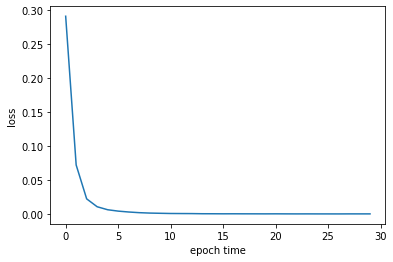

In [11]:
#before
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(device)
# net = get_seg_model(config).to(device)                
# loss_fn = nn.MSELoss()                                #損失関数の定義
# optimizer = optim.Adam(net.parameters(), lr = 0.01)

# losses = []                                     #epoch毎のlossを記録
# epoch_time = 30

# for epoch in range(epoch_time):
#     running_loss = 0.0                          #epoch毎のlossの計算
#     net.train()
#     for i, (XX, yy) in enumerate(data_loader):
#         optimizer.zero_grad()  
#         XX = XX.to(device) 
#         yy = yy.to(device)    
#         y_pred = net(XX)
#         loss = loss_fn(y_pred, yy)
#         loss.backward()
#         optimizer.step()
#         running_loss += loss.item()
#     print("epoch:",epoch, " loss:", running_loss/(i + 1))
#     losses.append(running_loss/(i + 1))

# #lossの可視化
# plt.plot(losses)
# plt.ylabel("loss")
# plt.xlabel("epoch time")
# plt.savefig("loss_auto")
# plt.show()

#Test model

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2952: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


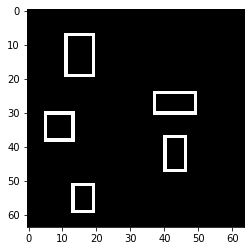

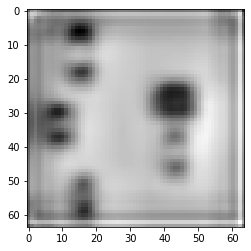

[]

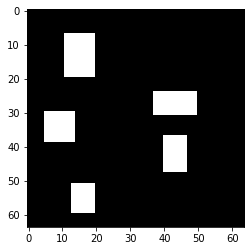

In [13]:
net.eval()            #評価モード
#今まで学習していない画像を1つ生成
num_images = 1
img_test = np.zeros([num_images, 3, length, length])
imgs_test_ano = np.zeros([num_images, 4, length, length])
for i in range(num_images):
    centers = []
    img = np.zeros([length, length])
    img_ano = np.zeros([length, length])
    for j in range(6):
        img, img_ano, centers = rectangle(img, img_ano, centers, 7)
    img_test[i, 0, :, :] = img

img_test = img_test.reshape([1, 3, 64, 64])
img_test = torch.tensor(img_test, dtype = torch.float32).to(device)
img_test = net(img_test).to(device)             #生成した画像を学習済のネットワークへ
img_test = img_test.cpu().detach().numpy() #torch.tensor - ndarray
img_test = img_test[0, 0, :, :]

plt.imshow(img, cmap = "gray")       #inputデータの可視化
plt.savefig("input_auto")
plt.show()
plt.imshow(img_test, cmap = "gray")  #outputデータの可視化
plt.savefig("output_auto")
plt.show()
plt.imshow(img_ano, cmap = "gray")   #正解データ
plt.savefig("correct_auto")
plt.plot()
